<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/tf2/fashion-mnist-resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion MNIST with Keras and Resnet

Adapted from 
* https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/fashion_mnist.ipynb
* https://github.com/margaretmz/deep-learning/blob/master/fashion_mnist_keras.ipynb

In [1]:
# Gives us a well defined version of tensorflow

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# will also work, but nightly build might contain surprises

# !pip install -q tf-nightly-gpu-2.0-preview

TensorFlow 2.x selected.


In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0-beta1


In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [4]:
x_train.shape

(60000, 28, 28)

In [0]:
import numpy as np

# add empty color dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [6]:
x_train.shape

(60000, 28, 28, 1)

In [0]:
# recude memory and compute time
NUMBER_OF_SAMPLES = 50000

In [0]:
x_train_samples = x_train[:NUMBER_OF_SAMPLES]

In [0]:
y_train_samples = y_train[:NUMBER_OF_SAMPLES]

In [0]:
import skimage.data
import skimage.transform

x_train_224 = np.array([skimage.transform.resize(image, (32, 32)) for image in x_train_samples])

In [11]:
x_train_224.shape

(50000, 32, 32, 1)

## Alternative: ResNet
* basic ideas
  * depth does matter
  * 8x deeper than VGG
  * possible by using shortcuts and skipping final fc layer
  * prevents vanishing gradient problem
* https://keras.io/applications/#resnet50
* https://medium.com/towards-data-science/neural-network-architectures-156e5bad51ba

http://arxiv.org/abs/1512.03385
![Deep Learning](https://raw.githubusercontent.com/DJCordhose/ai/master/docs/img/residual.png)

In [12]:
from tensorflow.keras.applications.resnet50 import ResNet50

# https://keras.io/applications/#mobilenet
# https://arxiv.org/pdf/1704.04861.pdf
from tensorflow.keras.applications.mobilenet import MobileNet

# might take forever to train, so we might prefer mobile net
model = ResNet50(classes=10, weights=None, input_shape=(32, 32, 1))
# model = MobileNet(classes=10, weights=None, input_shape=(32, 32, 1))

model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [20]:
%%time

BATCH_SIZE=10
EPOCHS = 10

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history = model.fit(x_train_224, y_train_samples, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, verbose=1)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 367s 9ms/sample - loss: 2.1359 - accuracy: 0.6839 - val_loss: 1.6405 - val_accuracy: 0.7349
Epoch 2/10
40000/40000 [==============================] - 364s 9ms/sample - loss: 2.2051 - accuracy: 0.6733 - val_loss: 6.0878 - val_accuracy: 0.4198
Epoch 3/10
40000/40000 [==============================] - 371s 9ms/sample - loss: 1.8638 - accuracy: 0.5915 - val_loss: 0.7253 - val_accuracy: 0.7355
Epoch 4/10
40000/40000 [==============================] - 368s 9ms/sample - loss: 0.8628 - accuracy: 0.6964 - val_loss: 0.9808 - val_accuracy: 0.7607
Epoch 5/10
40000/40000 [==============================] - 387s 10ms/sample - loss: 0.6601 - accuracy: 0.7635 - val_loss: 0.7733 - val_accuracy: 0.7983
Epoch 6/10
40000/40000 [==============================] - 364s 9ms/sample - loss: 0.5806 - accuracy: 0.7947 - val_loss: 0.7751 - val_accuracy: 0.7946
Epoch 7/10
40000/40000 [=========================

In [18]:
train_loss, train_accuracy = model.evaluate(x_train_224, y_train_samples, batch_size=BATCH_SIZE)
train_loss, train_accuracy

50000/50000 [==============================] - 52s 1ms/sample - loss: 1.1962 - accuracy: 0.7489


0.74892

In [19]:
test_loss, test_accuracy = model.evaluate(x_test_224, y_test, batch_size=BATCH_SIZE)
test_loss, test_accuracy

10000/10000 [==============================] - 10s 1ms/sample - loss: 1.2924 - accuracy: 0.7324


0.7324

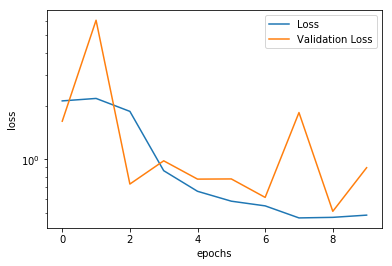

In [21]:
import matplotlib.pyplot as plt

plt.xlabel('epochs')
plt.ylabel('loss')

plt.yscale('log')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Validation Loss'])

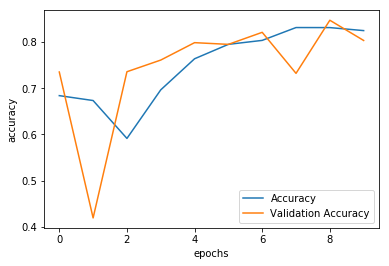

In [22]:
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Accuracy', 'Validation Accuracy'])

# Checking our results (inference)

In [0]:
x_test_224 = np.array([skimage.transform.resize(image, (32, 32)) for image in x_test])

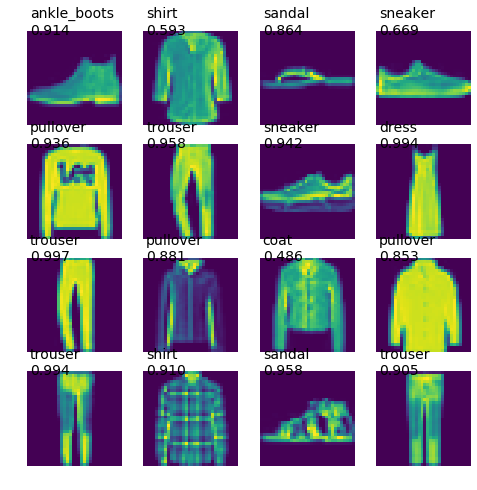

In [24]:
LABEL_NAMES = ['t_shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']


def plot_predictions(images, predictions):
  n = images.shape[0]
  nc = int(np.ceil(n / 4))
  f, axes = plt.subplots(nc, 4)
  for i in range(nc * 4):
    y = i // 4
    x = i % 4
    axes[x, y].axis('off')
    
    label = LABEL_NAMES[np.argmax(predictions[i])]
    confidence = np.max(predictions[i])
    if i > n:
      continue
    axes[x, y].imshow(images[i])
    axes[x, y].text(0.5, 0.5, label + '\n%.3f' % confidence, fontsize=14)

  plt.gcf().set_size_inches(8, 8)  

plot_predictions(np.squeeze(x_test_224[:16]), 
                 model.predict(x_test_224[:16]))